In [1]:
import re
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from utils import preprocess_image
np.random.seed(2000)

2023-07-14 16:25:52.160135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_path = '../tflite_models/float32/efficientdet.tflite'
img_path = './images/street.jpg'

In [3]:
LABEL_PATH = 'coco_labels.txt'
labels = dict()
with open(LABEL_PATH, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for row_number, content in enumerate(lines):
            pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
            if len(pair) == 2 and pair[0].strip().isdigit():
                labels[int(pair[0])] = pair[1].strip()
            else:
                labels[row_number] = pair[0].strip()
print(labels)
colors = np.random.randint(0, 255, size=(len(labels), 3),dtype="int32")

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic', 10: 'fire', 11: 'stop', 12: 'parking', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports', 33: 'kite', 34: 'baseball', 35: 'baseball', 36: 'skateboard', 37: 'surfboard', 38: 'tennis', 39: 'bottle', 40: 'wine', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted', 59: 'bed', 60: 'dining', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book'

In [4]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
img_shape = tuple(input_shape[1:3])
input_type = input_details[0]['dtype']
print(img_shape, input_type)

(512, 512) <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
img = tf.io.read_file(img_path)
img = tf.io.decode_image(img, channels=3)
original_img = img.numpy()
if type == np.uint8:
    img = tf.image.convert_image_dtype(img, tf.uint8)
else:
    img = tf.image.convert_image_dtype(img, tf.float32)
scaled_img = tf.image.resize(img, (512, 512))
scaled_img = scaled_img[tf.newaxis, :]

In [6]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()
out = interpreter.get_tensor(output_details[0]['index']).squeeze()
bboxes = out[:, 1:5]
scores = out[:, 5]
class_ids = out[:, 6].astype(int) - 1


In [7]:
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.4,
    score_threshold=0.2
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]

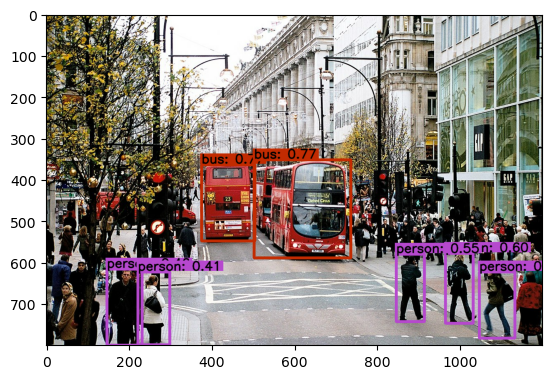

In [8]:

for bbox, score, class_id in zip(bboxes, scores, class_ids):

    label = labels[int(class_id)]
    color = tuple([int(c) for c in colors[int(class_id)]])
    y_min_scaled, x_min_scaled, y_max_scaled, x_max_scaled = bbox

    x_min_ratio = x_min_scaled / img_shape[1]
    y_min_ratio = y_min_scaled / img_shape[0]
    x_max_ratio = x_max_scaled / img_shape[1]
    y_max_ratio = y_max_scaled / img_shape[0]

    x_min = int(x_min_ratio * original_img.shape[1])
    y_min = int(y_min_ratio * original_img.shape[0])
    x_max = int(x_max_ratio * original_img.shape[1])
    y_max = int(y_max_ratio * original_img.shape[0])
    
    # Drawing bounding box
    cv2.rectangle(original_img, (x_min, y_min), (x_max, y_max), color, 6)
    # Drawing label
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    detection_info = f'{label}: {score:.2f}'
    label_size = cv2.getTextSize(detection_info, font_face, font_scale, font_thickness)[0]
    label_x_min, label_y_min = x_min - 3, y_min - 3
    label_x_max, label_y_max = x_min + 3 + label_size[0], y_min - 5 - label_size[1]
    cv2.rectangle(original_img, (label_x_min, label_y_min), (label_x_max, label_y_max), color, -1)
    cv2.putText(original_img, detection_info, (x_min, y_min - 4), font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

plt.imshow(original_img)